In [1]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

### P1: Understanding Alpha

#### P1A: Using Ridge instead of LinearRegression

In HW3, we had you fit a model to predict the x-y relationship given below.

In [3]:
p1_data = pd.read_csv("p1.csv")

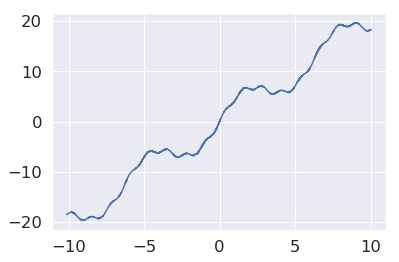

In [34]:
plt.plot(p1_data["x"], p1_data["y"])

In particular, we had you create a new dataframe with 3 features: x, sin(x) and sin(5x)

In [4]:
featurized_p1_data = pd.DataFrame({
    "phi1": p1_data["x"],
    "phi2": np.sin(p1_data["x"]),
    "phi3": np.sin(5*p1_data["x"])
})

To understand how regularization works, let's now try using the `Ridge` module instead of `LinearRegression`. Recall that `Ridge` takes an `alpha` parameter that lets us control the complexity of our model.

Let's start by using `alpha = 0`, which will make our model work exactly like `LinearRegression`.

In [61]:
p1_model_alpha0 = linear_model.Ridge(alpha = 0)
p1_model_alpha0.fit(featurized_p1_data, p1_data["y"])

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [62]:
p1_model_alpha0.coef_

array([2. , 3. , 0.5])

Observe above that the coefficients are exactly the same that we found in hw3.

Below:
1. Fit a model `p1_model_alpha100` that has an alpha value of 100. 
2. Print out the coefficients of the model and compare them to the coefficients for `p1_model`
3. Make a plot of the predictions made by `p1_model_alpha100` and compare them to the original data.

You should see that the coefficients are slightly smaller and the fit is not quite as good.

In [60]:
p1_model_alpha100 = linear_model.Ridge(alpha = 100)
p1_model_alpha100.fit(featurized_p1_data, p1_data["y"])

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [48]:
p1_model_alpha100.coef_

array([2.008366  , 2.09787207, 0.35873337])

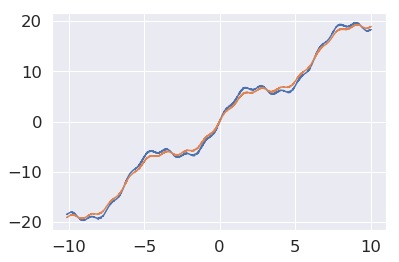

In [49]:
plt.plot(p1_data["x"], p1_data["y"])
plt.plot(p1_data["x"], p1_model_alpha100.predict(featurized_p1_data))

Now repeat the same exercise with alpha = 1000.

In [56]:
p1_model_alpha1000 = linear_model.Ridge(alpha = 1000)
p1_model_alpha1000.fit(featurized_p1_data, p1_data["y"])

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [57]:
p1_model_alpha1000.coef_

array([1.93820735, 0.59244613, 0.09695011])

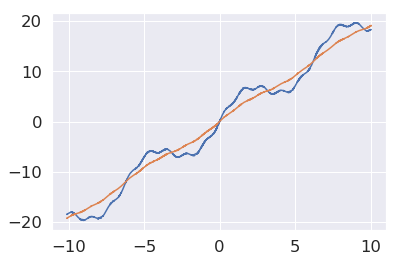

In [58]:
plt.plot(p1_data["x"], p1_data["y"])
plt.plot(p1_data["x"], p1_model_alpha1000.predict(featurized_p1_data))

You should see that the model has to spend much more of its "budget" on the linear coefficient, and isn't able to really capture much of the oscillating behavior.

#### P1B: Understanding Objective Functions

To get a better understanding for how $\alpha$ forces our parameters to be smaller, let's revisit the definition of our regularizaed model.

Recall that `Ridge` tries to minimize the sum of the mean squared error plus the squares of all the coefficients times alpha, i.e. $\text{MSE} + \alpha \sum_{i=1}^n \theta_i$.

For example, if our coefficients are `[2, 3, 0.5]`, then the MSE is effectively zero. 

In [73]:
mean_squared_error(p1_model_alpha0.predict(featurized_p1_data), p1_data["y"])

1.4278254502752007e-29

If our coefficients are `[2, 3, 0.5]` and `alpha = 100`, then the objective function is $0 + 100 \times (2^2 + 3^2 + 0.5^2) = 0$

In [74]:
np.sum(100 * [2 * 2 + 3 * 3 + 0.5 * 0.5])

1325.0

Or using `p1_model_alpha0` directly:

In [75]:
np.sum(100 * p1_model_alpha0.coef_**2)

1324.9999999999986

Below, compute the value of the objective function for alpha = 100 for `p1_model_alpha100`. Hint: The result should be approximately 856.

In [76]:
mean_squared_error(p1_model_alpha100.predict(featurized_p1_data), p1_data["y"]) + np.sum(100 * p1_model_alpha100.coef_**2)

856.7143683680949

The gives us some insight into how `alpha` works. When we tell `p1_model_alpha100` to `fit` itself to the data, it has to minimize two things at once: The MSE and $\alpha \sum_{i=1}^n \theta_i$. So when faced with a choice between `[2, 3, 0.5]` and `[2, 2.1, 0.36]`, it picks `[2, 2.1, 0.36]`. Even though `[2, 2.1, 0.36]` has worse MSE, it has better $\alpha \sum_{i=1}^n \theta_i$.

Lastly, compute the value of the objective function for `p1_model_alpha1000` and `alpha = 1000`.

In [79]:
mean_squared_error(p1_model_alpha1000.predict(featurized_p1_data), p1_data["y"]) + np.sum(1000 * p1_model_alpha1000.coef_**2)

4120.209862847307

### P2: Using Pipelines and Scaling

In [87]:
from sklearn.preprocessing import StandardScaler

In [105]:
houses = pd.read_csv("kc_house_data.csv")

In [106]:
houses.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [107]:
houses.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [108]:
p2_model = LinearRegression()

In [112]:
p2_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'condition', 'grade']

In [113]:
p2_model.fit(houses[p2_features], houses["price"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

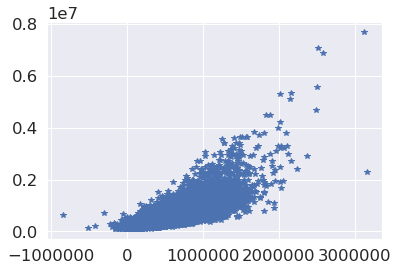

In [118]:
plt.plot(p2_model.predict(houses[p2_features]), houses["price"], '*')

In [119]:
mean_absolute_error(p2_model.predict(houses[p2_features]), houses["price"])

159169.29185847563

If we look at the features of our data, we see that the first feature is often much larger in magnitude than the other 2.

In [81]:
featurized_p1_data.head(10)

,phi1,phi2,phi3
0,-10.104576,0.628636,-0.254565
1,-10.117579,0.638695,-0.316854
2,-9.893642,0.451873,0.715452
3,-9.754603,0.323878,0.996934
4,-9.834811,0.398640,0.887286
5,-9.703887,0.275499,0.984682
6,-9.813888,0.379366,0.930597
7,-9.619956,0.193941,0.828200
8,-9.624693,0.198586,0.841242
9,-9.758159,0.327240,0.995385


In [84]:
np.var(featurized_p1_data)

phi1    33.376803
phi2     0.471973
phi3     0.488484
dtype: float64

This is part of the reason that our model needs a relatively large 

In [ ]:
Create a pipeline called 

In [100]:
p1_scaled_alpha100_model = Pipeline([
    ('scale', StandardScaler()),
    ('model', linear_model.Ridge(alpha=100))
])    
p1_scaled_alpha100_model.fit(featurized_p1_data, p1_data["y"])

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 Ridge(alpha=100, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [101]:
p1_scaled_alpha100_model.named_steps["model"].coef_

array([9.63105133, 2.03042076, 0.24272739])

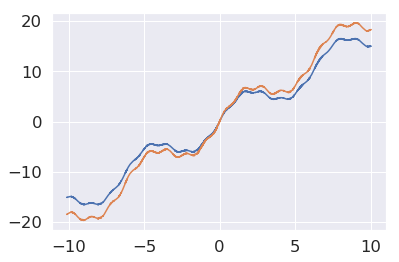

In [102]:
plt.plot(p1_data["x"], p1_scaled_alpha100_model.predict(featurized_p1_data))
plt.plot(p1_data["x"], p1_data["y"])